In [1]:
from utils.cluster import *
from utils.geo import *
from utils.loaddata import *
from utils.utils import *

In [2]:
from numpy import *
from tqdm import *
from sklearn.ensemble import IsolationForest

def get_centers(labels, flow):
    unique_labels = unique(labels)
    centers = []
    for label in unique_labels:
        centers.append(mean(flow[where(labels == label)], axis=0))
    return array(centers)

def iforest_ad(data, thresh = None):
    clf = IsolationForest(contamination=0.02, max_features=2)
    clf.fit(data)
    anomaly_score = clf.score_samples(data)
    anomaly_score = (anomaly_score-min(anomaly_score))/(max(anomaly_score)-min(anomaly_score))
    anomaly_score = 1 - anomaly_score
    if thresh == None:
        thresh = 90
    return where(anomaly_score >= percentile(anomaly_score, thresh))[0]

# get inflow, outflow data
inflow = load('./v2/gen_inflows.npy')
outflow = load('./v2/gen_outflows.npy')

inorm = norm_by_row(inflow)
onorm = norm_by_row(outflow)

aggl = load('./v2/aggl.npy')
ad_real = load('./v2/gen_anomalies.npy')

accs = []
recalls = []
f1s = []

tn = 6*7*24
rn = 256

for thresh in trange(79, 99):
    iforest_ads = array([])
    for t in range(0, tn):
        ad = array([0]*rn)
        for l in range(0, len(unique(aggl))):
            label_index = where(aggl == l)[0]
            io_norm = stack([inorm[label_index, t], onorm[label_index, t]], axis=1)
            ad_index = iforest_ad(io_norm, thresh)
            ad[label_index[ad_index]] = 1
        iforest_ads = concatenate([iforest_ads, ad])
    save('./iforest/' + str(thresh) + '.npy', iforest_ads)
    acc, recall = cal_param(iforest_ads, ad_real.T.flatten())
    accs.append(acc)
    recalls.append(recall)
    f1s.append((acc*recall)/(recall + acc))

100%|██████████| 20/20 [7:46:19<00:00, 1398.95s/it]  


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
/opt/conda/envs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


<Figure size 1440x1440 with 0 Axes>

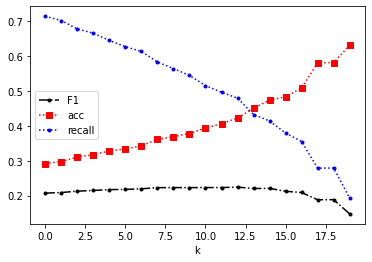

In [28]:
accs = []
recalls = []
f1s = []

def cal_param(pred, real):
    count= 0.0
    for i in range(len(pred)):
        if pred[i] == 1 and real[i] >= 1:
            count = count + 1
    return count/len(where(pred == 1)[0]), count/len(where(real >= 1)[0])

ad_real = load('./v2/gen_anomalies.npy')

for thresh in trange(79, 99):
    iforest_ads = load('./iforest/' + str(thresh) + '.npy')
    acc, recall = cal_param(iforest_ads, ad_real.T.flatten())
    accs.append(acc)
    recalls.append(recall)
    f1s.append((acc*recall)/(recall + acc))
    
fig = plt.figure(figsize=(20, 20))
_, ax = plt.subplots()
ax.plot(range(0, 20), f1s, c='k', ls='-.', marker='.', label='F1')
ax.plot(range(0, 20), accs, c='r', ls=':', marker='s', label='acc')
ax.plot(range(0, 20), recalls, c='b', ls=':', marker='.', label='recall')

ax.set_xlabel('k')
ax.legend()
ax1.set_xticks(range(0, 20), tuple(range(79, 99)))

plt.show()

In [29]:
save('./index/iforest_acc.npy', accs)
save('./index/iforest_recall.npy', recalls)
save('./index/iforest_f1.npy', recalls)

In [11]:
from utils.BaseSVDD import *

def svdd_ad(data, thresh = None):
    svdd = BaseSVDD(C=thresh, gamma=0.3, kernel='rbf', display='off')
    svdd.fit(data)
    anomaly_score = svdd.get_distance(data) - svdd.radius
#     anomaly_score = (anomaly_score-min(anomaly_score))/(max(anomaly_score)-min(anomaly_score))
    anomaly_score = array(anomaly_score).squeeze()
    return where(anomaly_score > 0)[0]

# get inflow, outflow data
inflow = load('./v2/gen_inflows.npy')
outflow = load('./v2/gen_outflows.npy')

inorm = norm_by_row(inflow)
onorm = norm_by_row(outflow)

aggl = load('./v2/aggl.npy')
ad_real = load('./v2/gen_anomalies.npy')

accs = []
recalls = []
f1s = []

for thresh in trange(79, 99):
    iforest_ads = array([])
    for t in range(0, tn):
        ad = array([0]*rn)
        for l in range(0, len(unique(aggl))):
            label_index = where(aggl == l)[0]
            io_norm = stack([inorm[label_index, t], onorm[label_index, t]], axis=1)
            ad_index = svdd_ad(io_norm, thresh)
            ad[label_index[ad_index]] = 1
        iforest_ads = concatenate([iforest_ads, ad])
    save('./svdd/' + str(thresh) + '.npy', iforest_ads)
    acc, recall = cal_param(iforest_ads, ad_real.T.flatten())
    accs.append(acc)
    recalls.append(recall)
    f1s.append((acc*recall)/(recall + acc))

  0%|          | 0/20 [00:00<?, ?it/s]/home/luojunhui1/0525/utils/BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
/home/luojunhui1/0525/utils/BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
/home/luojunhui1/0525/utils/BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
/home/luojunhui1/0525/utils/BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
/home/luojunhui1/0525/utils/BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
/home/luojunhui1/0525/utils/BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model ma

KeyboardInterrupt: 

100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
/opt/conda/envs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


<Figure size 1440x1440 with 0 Axes>

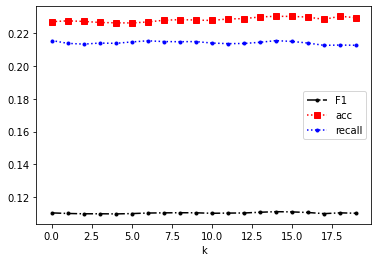

In [30]:
accs = []
recalls = []
f1s = []

ad_real = load('./v2/gen_anomalies.npy')

for thresh in trange(79, 99):
    iforest_ads = load('./svdd/' + str(thresh) + '.npy')
    acc, recall = cal_param(iforest_ads, ad_real.T.flatten())
    accs.append(acc)
    recalls.append(recall)
    f1s.append((acc*recall)/(recall + acc))
                       
fig = plt.figure(figsize=(20, 20))
_, ax = plt.subplots()
ax.plot(range(0, 20), f1s, c='k', ls='-.', marker='.', label='F1')
ax.plot(range(0, 20), accs, c='r', ls=':', marker='s', label='acc')
ax.plot(range(0, 20), recalls, c='b', ls=':', marker='.', label='recall')

ax.set_xlabel('k')
ax.legend()
ax1.set_xticks(range(0, 20), tuple(range(79, 99)))

plt.show()

In [31]:
save('./index/svdd_acc.npy', accs)
save('./index/svdd_recall.npy', recalls)
save('./index/svdd_f1.npy', f1s)

In [25]:
def chisquare_ad(data, k = 3):
    means = mean(data,axis=0)
    chi = [sum(((data[i] - means)**2)/means) for i in range(0, len(data))]
    cur = chi - mean(chi)
    anomaly_score = [0 if cur[i] < 0 else cur[i] for i in range(0, len(cur))]
    return where(anomaly_score >= k)[0]

accs = []
recalls = []
f1s = []

for thresh in tqdm(linspace(0, 0.3, 10, endpoint=False)):
    print(thresh)
    iforest_ads = array([])
    for t in range(0, tn):
        ad = array([0]*rn)
        for l in range(0, len(unique(aggl))):
            label_index = where(aggl == l)[0]
            io_norm = stack([inorm[label_index, t], onorm[label_index, t]], axis=1)
            ad_index = chisquare_ad(io_norm, thresh)
            ad[label_index[ad_index]] = 1
        iforest_ads = concatenate([iforest_ads, ad])
    save('./chis/' + str(thresh) + '.npy', iforest_ads)
    acc, recall = cal_param(iforest_ads, ad_real.T.flatten())
    accs.append(acc)
    recalls.append(recall)
    f1s.append((acc*recall)/(recall + acc))

  0%|          | 0/10 [00:00<?, ?it/s]

0.0


 10%|█         | 1/10 [00:03<00:31,  3.52s/it]

0.03


 20%|██        | 2/10 [00:06<00:27,  3.45s/it]

0.06


 30%|███       | 3/10 [00:10<00:23,  3.41s/it]

0.09


 40%|████      | 4/10 [00:13<00:20,  3.40s/it]

0.12


 50%|█████     | 5/10 [00:17<00:16,  3.39s/it]

0.15


 60%|██████    | 6/10 [00:20<00:13,  3.39s/it]

0.18


 70%|███████   | 7/10 [00:23<00:10,  3.38s/it]

0.21


 80%|████████  | 8/10 [00:27<00:06,  3.38s/it]

0.24


 90%|█████████ | 9/10 [00:30<00:03,  3.38s/it]

0.27


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

<Figure size 1440x1440 with 0 Axes>

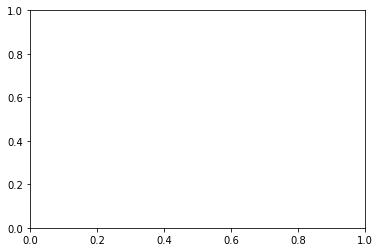

In [32]:
accs = []
recalls = []
f1s = []

ad_real = load('./v2/gen_anomalies.npy')

for thresh in linspace(0, 0.3, 10, endpoint=False):
    iforest_ads = load('./chis/' + str(thresh) + '.npy')
    acc, recall = cal_param(iforest_ads, ad_real.T.flatten())
    accs.append(acc)
    recalls.append(recall)
    f1s.append((acc*recall)/(recall + acc))
   
fig = plt.figure(figsize=(20, 20))
_, ax = plt.subplots()
ax.plot(range(0, 10), f1s, c='k', ls='-.', marker='.', label='F1')
ax.plot(range(0, 10), accs, c='r', ls=':', marker='s', label='acc')
ax.plot(range(0, 20), recalls, c='b', ls=':', marker='.', label='recall')

ax.set_xlabel('k')
ax.legend()
ax1.set_xticks(range(0, 20), tuple(range(79, 99)))

plt.show()

In [27]:
save('./index/chis_acc.npy', accs)
save('./index/chis_recall.npy', recalls)
save('./index/chis_f1.npy', f1s)